In [1]:
import pandas as pd
import requests
import spotipy
import spotipy.util as util
from spotipy.oauth2 import SpotifyClientCredentials
import spotipy.oauth2 as oauth2
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats 
import math
import matplotlib.collections as clt
import ptitprince as pt
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats import weightstats as stests

In [13]:
spotify_lst = ['606FB2E4VYYs9CJSLCnhUa', '4Ur5dnjKkGgjPSJpwKBHDd', 
               '5zP5a7VWRgvjCi6ra3IeJ0', '7CIeE38SdXZ9J0M76QRhmS',
               '0H3MpEFBNTXwPzPqz8yj6V', '69dtPFfkYa5URry1zo665z',
               '5ows8MyC8CN95GTbgTovnd', '6q6DzFMMwpYeU2a90J5IyJ',
               '3DyizJDVdHipO17XqQeK5f', '4J4rsjuzvXNcF996nPP2pG',
               '7MMIVoteyDNzNp7PJUCeG4', '6BGXLlqwvOkM4JdWXxjmER',
               '6EaLmdD8KZvXiBER0VgY8L', '1bk6tO6d5oes6n0vhACi5x',
               '74BP9iaXq354DmPUepjzNC', '1ux0KmjmnQCNQzQ0BH7kbl',
               '3lluUY967E5z4WnNeJKDV2', '2FEAysct4thAiYGojrHKlM',
               '3fniVM8pbMq8jcR23aVIY8', '6D0WkFzwCx5pxfD5jX0wkL',
               '6taan6n01bwB2B7EtN9KYI', '2mI2QBJDL4klpigMkqaFs5',
               '61FusglQju0yXpz3v7nYd5', '0p6VwHqAZNV9xw5HuIKHJd',
               '35wZqszdyXNFCAztyLWlgT', '7A1EbS3Zux6zhXyeSpHEx9',
               '5zYgmmRp9ozLstVry1JLbw', '0YKbjLgCPsp7K3k2JH4NZw',
               '6NewzRggzRDBBPowRuXBor', '0ytSNwG5nGYtB01bnmy4CY',
               '7gTvhRcUZaXt8ydN3AAIqF', '6sBduygGNeCecOenI9ZZ2F',
               '0vqKnSeWspiQ9EHhWM8ZFD', '6B7HuyxqWvbBkFMErD64VC',
               '2nAvu6nKy5YMZnjJjAA5et', '1FtOhbe9MmxVq3yhU9AYzP',
               '71ok4KKSKzVKTudbTsyLFS', '2wkM6gBP77AQB4hFwutvy4',
               '5DxEF8AgbkfjixhPVzRTqA', '4Qk6DsuSEp34mm8K7MuXH9',
               '1uFaOr8h7OeCG1atiUGaVN', '7iUo5BVXvkRKzzlX0ozIdA',
               '6qsTClrBMf59rUNnD3fzWc', '2Inm8T8QcA90nbOGshxHLo',
               '6AihpQrTXtgDnkcQwLfxYb', '5ohzMZ3OBvDlHypXCBKrHa',
               '3XdhaqlOYFr5484hWYHmTB', '5cIzPoYKkD0HtGKZ0ZDWMx',
               '1WvCS1o0lfs66CSxo4Ex49', '4bSNhfnKA9mr3ARsMpnau0']




In [14]:
len(spotify_lst)



50

In [15]:
def get_auth():
    CLIENT_ID ='50b2240e93784d028ba2eb626095dd6c'
    CLIENT_SECRET = '07e055a4f4fe4b9d83ad3e6961bb40f2'

    credentials = SpotifyClientCredentials(
            client_id=CLIENT_ID,
            client_secret=CLIENT_SECRET)

    token = credentials.get_access_token()
    return "Bearer " + token


In [16]:
get_auth()

'Bearer BQBknN3GP3q4Vva6bkfVvdRc_PVNijF7Jxc7Dc9nZY8yGp-vfdptBq2LSnqTH8UozI1Uiws-u3SsHXN2RjM'

In [27]:
def get_tracks(lst = spotify_lst):
    x= 1969
    df_list=[]
    for playlist in lst:
    

        r = requests.get(
        f"https://api.spotify.com/v1/playlists/{playlist}/tracks",
        headers={ "Accept": "application/json", "Content-Type": "application/json", "Authorization": get_auth()})
        dat =r.json()
        
        data = dat['items']
        tracks_list=[]

        for i in range(0,len(data)):
           
            tracks_list.append({"track_name" : data[i]['track']['name'], "artist" : data[i]['track']['artists'][0]['name'],
                "album" : data[i]['track']['album']['name'], "release_date" : data[i]['track']['album']['release_date'],  
                "year" : x, "explicit" : data[i]['track']['explicit'], 
                "artist_id" : data[i]['track']['artists'][0]['id'], "album_id" : data[i]['track']['album']['id'], 
                "track_id" : data[i]['track']['id']})
        
        df_list.append(pd.DataFrame(tracks_list))
        
        x += 1
        
    tracks_df = pd.concat(df_list)
    tracks_df = tracks_df.reset_index()
    tracks_df.drop('index', axis = 1, inplace=True)
    return tracks_df
tracks_df = get_tracks()

#%%



In [60]:
def get_missing_tracks(df):
    null_df =df[df.track_id.isnull()]
    null_track_info = []
    count = 0
    for row in null_df.itertuples():
        track = getattr(row, 'track_name').replace(" ", "%20")
        artist = getattr(row, 'artist').replace(" ", "%20")
        
        
        q = requests.get(
            f"https://api.spotify.com/v1/search?q=track:{track}%20artist:{artist}&type=track" ,
            headers={ "Accept": "application/json", "Content-Type": "application/json", "Authorization": get_auth()},
            params= {'limit':1})
        try:
            null_track = q.json()
            
            null_track_info.append({'release_date': null_track['tracks']['items'][0]['album']['release_date'], 
                'explicit': null_track['tracks']['items'][0]['explicit'],
                'artist_id': null_track['tracks']['items'][0]['artists'][0]['id'],
                'album_id': null_track['tracks']['items'][0]['album']['id'],
                'track_id': null_track['tracks']['items'][0]['id']})
        except(IndexError):
             null_track_info.append({'release_date': np.nan, 
                'explicit': np.nan,
                'artist_id': np.nan ,
                'album_id': np.nan,
                'track_id': np.nan })
             
        count +=1
    null_track_info_df = pd.DataFrame(null_track_info, index=null_df.index)
    null_df.fillna(null_track_info_df, inplace=True)
    df.fillna(null_df, inplace = True)
    df.dropna(inplace = True)
    return df
# get_missing_tracks()

In [61]:
def get_track_info(df):
    track_info=[]
    for row in df.itertuples():
        track_id = getattr(row, 'track_id')
        
        q = requests.get(
            f"https://api.spotify.com/v1/audio-features/{track_id}" ,
            headers={ "Accept": "application/json", "Content-Type": "application/json", "Authorization": get_auth()})
        track_features = q.json()
        try:
            track_info.append({'danceability': track_features['danceability'], 'energy': track_features['energy'],
                           'key': track_features['key'], 'loudness': track_features['loudness'], 
                           'mode': track_features['mode'], 'speechiness': track_features['speechiness'],
                           'acousticness': track_features['acousticness'], 
                           'instrumentalness': track_features['instrumentalness'], 'liveness': track_features['liveness'],
                           'valence': track_features['valence'], 'tempo': track_features['tempo'], 
                           'duration_ms': track_features['duration_ms'], 'time_signature': track_features['time_signature']})
        except(KeyError):
            track_info.append({'danceability': np.nan, 'energy': np.nan, 'key': np.nan, 'loudness': np.nan, 'mode': np.nan, 
                               'speechiness': np.nan, 'acousticness': np.nan, 'instrumentalness': np.nan, 'liveness': np.nan,
                               'valence': np.nan, 'tempo': np.nan, 'duration_ms': np.nan, 'time_signature': np.nan})
    
    track_info_df = pd.DataFrame(track_info)
    df= df.join(track_info_df)

    return df

# get_track_info()

In [39]:
def get_data(lst=spotify_lst):
    tracks_df = get_tracks()
    tracks_df = get_missing_tracks(tracks_df)
    return  get_track_info(tacks_df)

In [62]:
tracks_df = get_tracks()

In [63]:
tracks_df = get_missing_tracks(tracks_df)

In [66]:
tracks_df = get_track_info(tracks_df)

KeyboardInterrupt: 

In [30]:
tracks_df.dropna(inplace = True)

In [6]:
tracks_df = pd.read_csv('tracks_csv.csv')

(array([  28.,  103.,  221.,  403.,  691.,  931., 1114.,  767.,  362.,
          95.]),
 array([0.149 , 0.2327, 0.3164, 0.4001, 0.4838, 0.5675, 0.6512, 0.7349,
        0.8186, 0.9023, 0.986 ]),
 <a list of 10 Patch objects>)

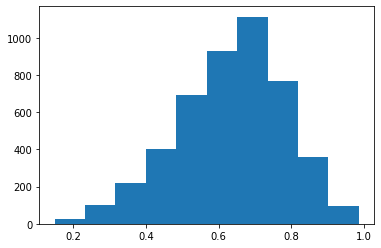

In [7]:
plt.hist(tracks_df['danceability'])

(array([ 11.,  64., 163., 355., 596., 731., 871., 837., 769., 318.]),
 array([0.0204 , 0.11806, 0.21572, 0.31338, 0.41104, 0.5087 , 0.60636,
        0.70402, 0.80168, 0.89934, 0.997  ]),
 <a list of 10 Patch objects>)

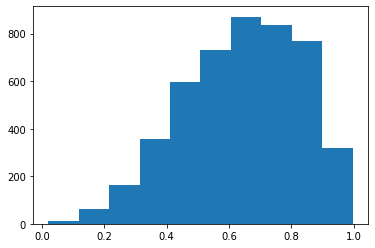

In [8]:
plt.hist(tracks_df['energy'])

In [9]:
tracks_df.artist.value_counts()

Madonna            36
Rihanna            31
Mariah Carey       31
Janet Jackson      27
Elton John         26
                   ..
Teena Marie         1
Rockwell            1
Jon Bon Jovi        1
Plain White T's     1
Tweet               1
Name: artist, Length: 1833, dtype: int64

In [10]:
tracks_groupd_by_year_mean = tracks_df.groupby('year').mean()

In [11]:
tracks_groupd_by_year_mean.head()

,Unnamed: 0,Unnamed: 0.1,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
year,,,,,,,,,,,,,,,,
1969,49.5,49.500000,0.0,0.536120,0.462129,5.170000,-11.640100,0.810000,0.047170,0.387787,0.032163,0.202622,0.595190,117.611130,194248.520000,3.910000
1970,149.5,149.500000,0.0,0.559780,0.601260,5.140000,-10.172190,0.840000,0.049502,0.313142,0.037285,0.193160,0.675520,119.942320,200823.840000,3.960000
1971,247.5,249.770833,0.0,0.570667,0.547966,4.604167,-10.708917,0.729167,0.050941,0.415658,0.022772,0.193549,0.683438,113.191031,206075.250000,3.968750
1972,345.5,349.500000,0.0,0.576670,0.547614,5.250000,-10.677650,0.750000,0.058205,0.404690,0.040947,0.195288,0.655470,122.068070,210260.560000,3.940000
1973,444.5,450.255102,0.0,0.572122,0.556796,5.193878,-10.576571,0.663265,0.059070,0.346678,0.053900,0.158622,0.686991,124.273724,231690.795918,3.908163


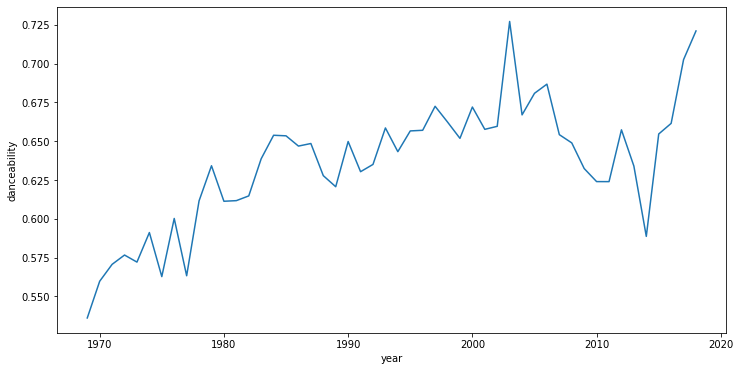

In [12]:
import seaborn as sns
plt.figure(figsize = (12,6))
f = sns.lineplot(tracks_groupd_by_year_mean.index, tracks_groupd_by_year_mean['danceability'])


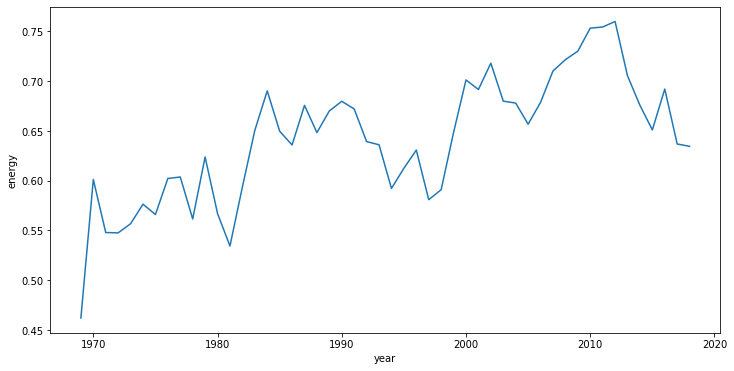

In [13]:
plt.figure(figsize = (12,6))
g = sns.lineplot(tracks_groupd_by_year_mean.index, tracks_groupd_by_year_mean['energy'])

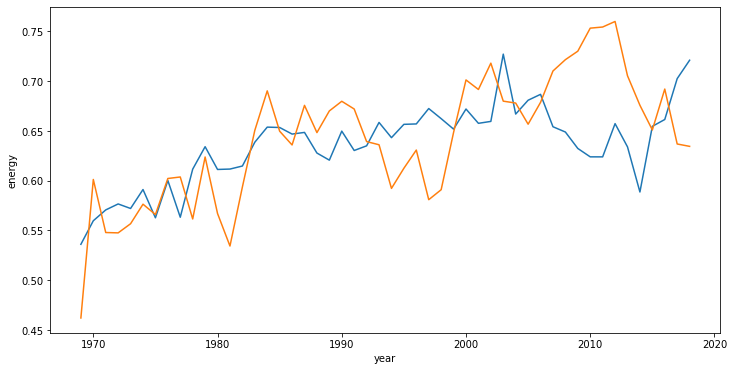

In [14]:
plt.figure(figsize = (12,6))
ax = sns.lineplot(tracks_groupd_by_year_mean.index, tracks_groupd_by_year_mean['danceability'])
ax2 = sns.lineplot(tracks_groupd_by_year_mean.index, tracks_groupd_by_year_mean['energy'])

In [15]:
worldbank = pd.read_csv('worldbank_data.csv')

In [16]:
worldbank = worldbank.transpose()

In [17]:
worldbank = worldbank.iloc[4:,0:3]

In [18]:
worldbank.head()

,0,1,2
1970 [YR1970],23207.2199359187,-0.254079592763361,-1.40937952140189
1971 [YR1971],23670.3457327086,3.29336237989513,1.99561084037087
1972 [YR1972],24649.8447359645,5.2588953573494,4.13808490301166
1973 [YR1973],25794.1281658637,5.64571947000461,4.64215268759745
1974 [YR1974],25421.3696704294,-0.540546528852801,-1.44512926755014


In [22]:
worldbank.rename(columns = {0 : 'gdp_pc', 1: 'gdp_growth', 2:'gdp_growth_pc'}, inplace =True)

In [23]:
worldbank.head()

,gdp_pc,gdp_growth,gdp_growth_pc
1970 [YR1970],23207.2199359187,-0.254079592763361,-1.40937952140189
1971 [YR1971],23670.3457327086,3.29336237989513,1.99561084037087
1972 [YR1972],24649.8447359645,5.2588953573494,4.13808490301166
1973 [YR1973],25794.1281658637,5.64571947000461,4.64215268759745
1974 [YR1974],25421.3696704294,-0.540546528852801,-1.44512926755014


In [24]:
worldbank['year'] = [x for x in range(1970, 2020)]

In [25]:
worldbank.info()

<class 'pandas.core.frame.DataFrame'>
Index: 50 entries, 1970 [YR1970] to 2019 [YR2019]
Data columns (total 4 columns):
gdp_pc           50 non-null object
gdp_growth       50 non-null object
gdp_growth_pc    50 non-null object
year             50 non-null int64
dtypes: int64(1), object(3)
memory usage: 2.0+ KB


In [26]:
worldbank['gdp_growth'] = worldbank['gdp_growth'].apply(pd.to_numeric, errors = 'coerce')

[(2005, 2019)]

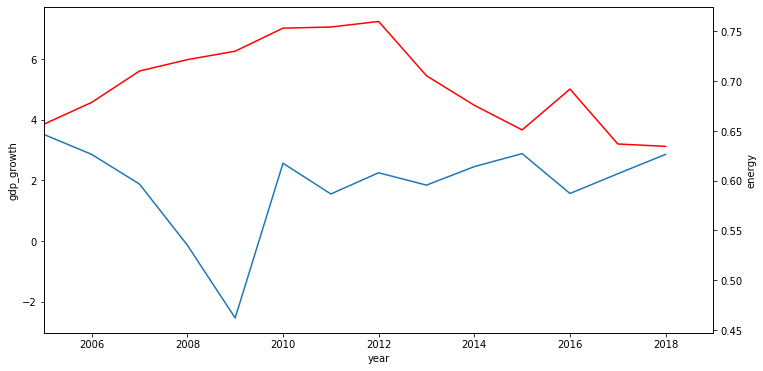

In [68]:
plt.figure(figsize = (12,6))

ax = sns.lineplot(worldbank['year'], worldbank['gdp_growth'])
ax2 = ax.twinx()
ax2 = sns.lineplot(tracks_groupd_by_year_mean.index, tracks_groupd_by_year_mean['energy'], color = 'red')
ax.set(xlim=(2005,2019))

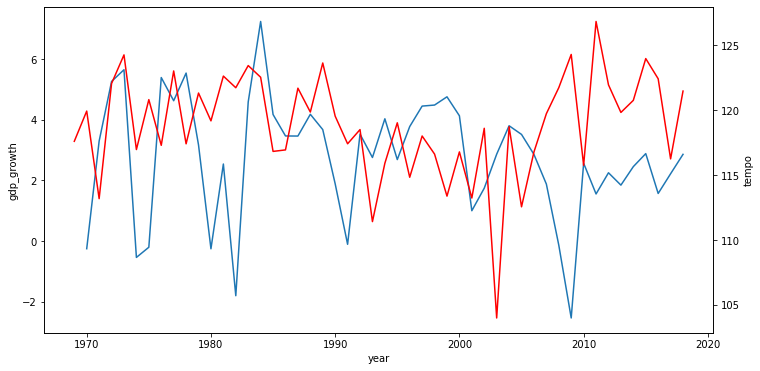

In [28]:
plt.figure(figsize = (12,6))
ax = sns.lineplot(worldbank['year'], worldbank['gdp_growth'])
ax2 = ax.twinx()
ax2 = sns.lineplot(tracks_groupd_by_year_mean.index, tracks_groupd_by_year_mean['tempo'], color = 'red')

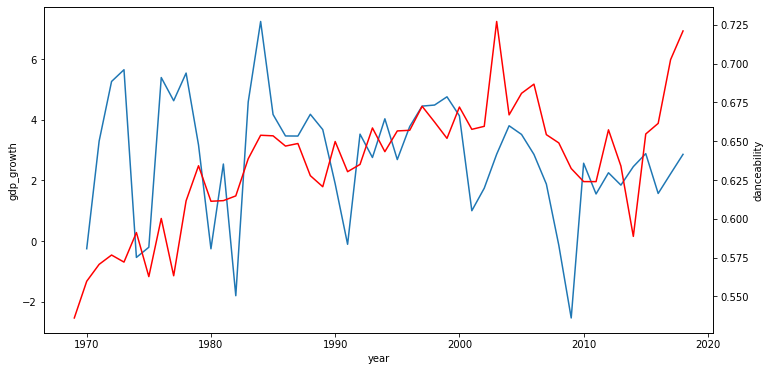

In [29]:

plt.figure(figsize = (12,6))
ax = sns.lineplot(worldbank['year'], worldbank['gdp_growth'])
ax2 = ax.twinx()
ax2 = sns.lineplot(tracks_groupd_by_year_mean.index, tracks_groupd_by_year_mean['danceability'], color = 'red')

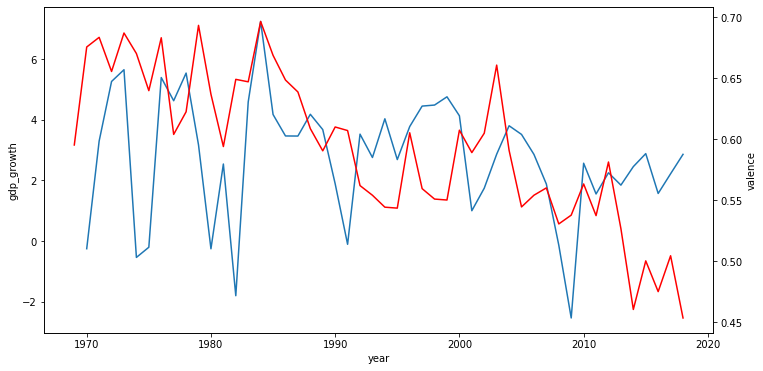

In [30]:

plt.figure(figsize = (12,6))
ax = sns.lineplot(worldbank['year'], worldbank['gdp_growth'])
ax2 = ax.twinx()
ax2 = sns.lineplot(tracks_groupd_by_year_mean.index, tracks_groupd_by_year_mean['valence'], color = 'red')

In [31]:
tracks_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4715 entries, 0 to 4714
Data columns (total 24 columns):
Unnamed: 0          4715 non-null int64
Unnamed: 0.1        4715 non-null int64
track_name          4715 non-null object
artist              4715 non-null object
album               4715 non-null object
release_date        4715 non-null object
year                4715 non-null int64
explicit            4715 non-null bool
artist_id           4715 non-null object
album_id            4715 non-null object
track_id            4715 non-null object
danceability        4715 non-null float64
energy              4715 non-null float64
key                 4715 non-null float64
loudness            4715 non-null float64
mode                4715 non-null float64
speechiness         4715 non-null float64
acousticness        4715 non-null float64
instrumentalness    4715 non-null float64
liveness            4715 non-null float64
valence             4715 non-null float64
tempo               4715 no

In [32]:
pop_sample.head()

NameError: name 'pop_sample' is not defined

# Test 1

## Energy

In [33]:
def get_sample(data, n):
    sample = []
    while len(sample) != n:
        x = np.random.choice(data)
        sample.append(x)
    
    return sample

def get_sample_mean(sample):
    return sum(sample) / len(sample)


def create_sample_distribution(data, dist_size=1000, n=1000):
    sample_dist = []
    while len(sample_dist) != dist_size:
        sample = get_sample(data, n)
        sample_mean = get_sample_mean(sample)
        sample_dist.append(sample_mean)
    
    return sample_dist

In [34]:
tracks2009=tracks_df[tracks_df['year']==2009]

sample_2009 = create_sample_distribution(tracks2009['energy'], dist_size=100, n=40)

stats.normaltest(sample_2009)

NormaltestResult(statistic=1.9986855437959137, pvalue=0.3681213013482907)

In [35]:
sample_population = create_sample_distribution(tracks_df['energy'], dist_size=100, n=40)
stats.normaltest(sample_population)

NormaltestResult(statistic=0.2151619271833869, pvalue=0.898003813893342)

Text(0.5, 0, 'Energy')

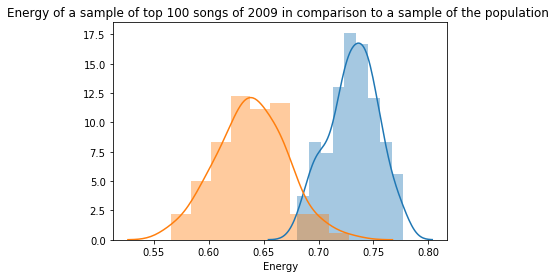

In [36]:
sns.distplot(sample_2009, label = "2009" )
sns.distplot(sample_population, label = 'Population')
plt.title('Energy of a sample of top 100 songs of 2009 in comparison to a sample of the population ')
plt.xlabel('Energy')

In [38]:
from scipy.stats import ttest_ind


sample_2009_mean = np.mean(sample_2009)
sample_pop_mean = np.mean(sample_population)
print("2009 mean value:",sample_2009_mean)
print("Population mean value:",sample_pop_mean)
sample_2009_std = np.std(sample_2009)
sample_pop_std = np.std(sample_population)
print("2009 std value:",sample_2009_std)
print("pop std value:",sample_pop_std)
ttest,pval = ttest_ind(sample_2009,sample_population)
print("p-value",pval)
if pval <0.05:
  print("we reject null hypothesis")
else:
  print("we accept null hypothesis")

2009 mean value: 0.7314882500000001
Population mean value: 0.6387268500000001
2009 std value: 0.022224977349538492
pop std value: 0.031218434805455896
p-value 9.437042346216665e-61
we reject null hypothesis


In [81]:

import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats import weightstats as stests

In [166]:
from scipy import stats

In [39]:
def welch_ttest(x, y): 
    ## Welch-Satterthwaite Degrees of Freedom ##
    dof = (x.var()/x.size + y.var()/y.size)**2 / ((x.var()/x.size)**2 / (x.size-1) + (y.var()/y.size)**2 / (y.size-1))
   
    t, p = stats.ttest_ind(x, y, equal_var = False)
    
    print("\n",
          f"Welch's t-test= {t:.4f}", "\n",
          f"p-value = {p:.4f}", "\n",
          f"Welch-Satterthwaite Degrees of Freedom= {dof:.4f}")


In [41]:
twenty_years = pd.read_csv('20 year songs.csv')

In [42]:
twenty_years.head()

,Unnamed: 0,Unnamed: 0.1,artist_name,release_date,track_name,track_id,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
0,0,0,TLC,1999-02-23,No Scrubs,1KGi9sZVMeszgZOWivFpxs,81,0.0251,0.743,214400,0.675,0.000717,8,0.0685,-4.267,0,0.0953,92.909,4,0.590
1,1,1,blink-182,1999-06-01,All The Small Things,2m1hi0nfMR9vdGC8UcrnwU,80,0.0103,0.434,167067,0.897,0.000000,0,0.6120,-4.918,1,0.0488,148.726,4,0.684
2,2,2,Smash Mouth,1999-01-01,All Star,3cfOd4CMv2snFaKAnMdnvK,81,0.0319,0.731,200373,0.861,0.000000,11,0.0829,-5.881,1,0.0323,104.034,4,0.780
3,3,3,Destiny's Child,1999-07-27,Say My Name,7H6ev70Weq6DdpZyyTmUXk,78,0.2730,0.713,271333,0.678,0.000000,5,0.1490,-3.525,0,0.1020,138.009,4,0.734
4,4,4,Red Hot Chili Peppers,1999-06-08,Californication,48UPSzbZjgc449aqz8bxox,82,0.0021,0.592,329733,0.767,0.001650,9,0.1270,-2.788,0,0.0270,96.483,4,0.328


In [43]:
twenty_years.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 201707 entries, 0 to 201706
Data columns (total 20 columns):
Unnamed: 0          201707 non-null int64
Unnamed: 0.1        201707 non-null int64
artist_name         201707 non-null object
release_date        201707 non-null object
track_name          201707 non-null object
track_id            201707 non-null object
popularity          201707 non-null int64
acousticness        201707 non-null float64
danceability        201707 non-null float64
duration_ms         201707 non-null int64
energy              201707 non-null float64
instrumentalness    201707 non-null float64
key                 201707 non-null int64
liveness            201707 non-null float64
loudness            201707 non-null float64
mode                201707 non-null int64
speechiness         201707 non-null float64
tempo               201707 non-null float64
time_signature      201707 non-null int64
valence             201707 non-null float64
dtypes: float64(9), int64(7

In [44]:
twenty_years['year'] = twenty_years.release_date.str[0:4]

In [45]:
twenty_years.head()

,Unnamed: 0,Unnamed: 0.1,artist_name,release_date,track_name,track_id,popularity,acousticness,danceability,duration_ms,...,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,year
0,0,0,TLC,1999-02-23,No Scrubs,1KGi9sZVMeszgZOWivFpxs,81,0.0251,0.743,214400,...,0.000717,8,0.0685,-4.267,0,0.0953,92.909,4,0.590,1999
1,1,1,blink-182,1999-06-01,All The Small Things,2m1hi0nfMR9vdGC8UcrnwU,80,0.0103,0.434,167067,...,0.000000,0,0.6120,-4.918,1,0.0488,148.726,4,0.684,1999
2,2,2,Smash Mouth,1999-01-01,All Star,3cfOd4CMv2snFaKAnMdnvK,81,0.0319,0.731,200373,...,0.000000,11,0.0829,-5.881,1,0.0323,104.034,4,0.780,1999
3,3,3,Destiny's Child,1999-07-27,Say My Name,7H6ev70Weq6DdpZyyTmUXk,78,0.2730,0.713,271333,...,0.000000,5,0.1490,-3.525,0,0.1020,138.009,4,0.734,1999
4,4,4,Red Hot Chili Peppers,1999-06-08,Californication,48UPSzbZjgc449aqz8bxox,82,0.0021,0.592,329733,...,0.001650,9,0.1270,-2.788,0,0.0270,96.483,4,0.328,1999


In [46]:
tracks_1999 = twenty_years[twenty_years['year']=='1999']
stats.normaltest(tracks_1999['danceability'])

NormaltestResult(statistic=316.44772538776743, pvalue=1.924196970850581e-69)

In [47]:
tracks_2018 = twenty_years[twenty_years['year']=='2018']

In [48]:
tracks_99_18 = pd.concat([tracks_1999,tracks_2018])

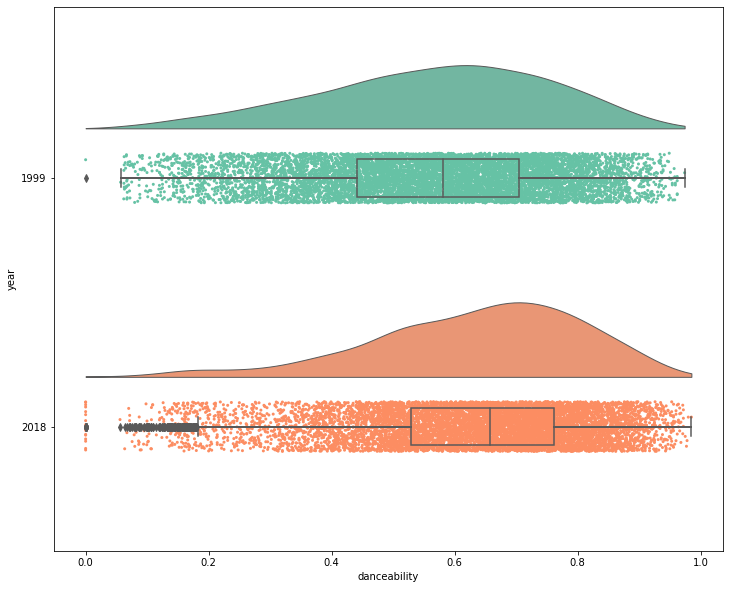

In [49]:
dx = "year"; dy = 'danceability'; ort = "h"; pal = "Set2"; sigma = .2
f, ax = plt.subplots(figsize=(12, 10))

pt.RainCloud(x = dx, y = dy, data = tracks_99_18, palette = pal, bw = sigma,
                 width_viol = .6, ax = ax, orient = ort, move = 0)

In [50]:
dist1999  =  create_sample_distribution(tracks_1999['danceability'])

In [51]:
stats.normaltest(dist1999)

NormaltestResult(statistic=0.29599053818003274, pvalue=0.8624351950356686)

In [53]:
dist2018_n1000 =  create_sample_distribution(tracks_2018['danceability'])
stats.normaltest(dist2018_n1000)

NormaltestResult(statistic=0.924705245187135, pvalue=0.6298002189951303)

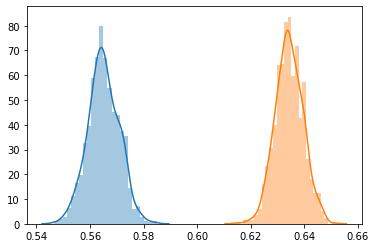

In [55]:
sns.distplot(dist1999)
sns.distplot(dist2018_n1000)

In [56]:
dist99_df = pd.DataFrame(dist1999)
dist99_df['year']=1999
type(dist99_df)

pandas.core.frame.DataFrame

In [57]:
dist18_df = pd.DataFrame(dist2018_n1000)
dist18_df['year']=2018
dist18_df.head()

,0,year
0,0.626576,2018
1,0.639704,2018
2,0.634007,2018
3,0.637152,2018
4,0.623309,2018


In [58]:
dist_concat = pd.concat([dist99_df, dist18_df])
dist_concat.rename(columns = {0:'Danceability'})
dist_concat.head()

,0,year
0,0.571150,1999
1,0.572827,1999
2,0.570062,1999
3,0.565356,1999
4,0.550370,1999


Text(0.5, 1.0, '20 year Comparison of Songs Danceability')

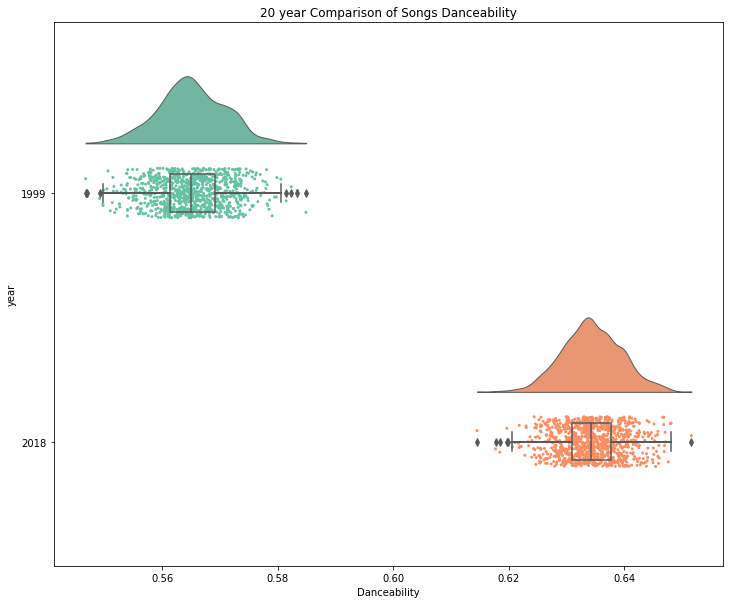

In [59]:
dx = "year"; dy = 0; ort = "h"; pal = "Set2"; sigma = .2
f, ax = plt.subplots(figsize=(12, 10))

pt.RainCloud(x = dx, y = dy, data = dist_concat, palette = pal, bw = sigma,
                 width_viol = .6, ax = ax, orient = ort, move = 0)
plt.xlabel('Danceability')
plt.title('20 year Comparison of Songs Danceability')

In [60]:
welch_ttest(dist99_df[0],dist18_df[0])


 Welch's t-test= -281.5206 
 p-value = 0.0000 
 Welch-Satterthwaite Degrees of Freedom= 1970.4938


In [414]:
lst_dfs = []
for x in range(1999,2018):
    print(x)
    df = twenty_years[twenty_years['year']== str(x)]
    dist =  create_sample_distribution(df['danceability'])
    dist_df = pd.DataFrame(dist)
    dist_df['year']= x
    lst_dfs.append(dist_df)

1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017


In [415]:
lst_dfs

[            0  year
 0    0.565908  1999
 1    0.566179  1999
 2    0.575705  1999
 3    0.569481  1999
 4    0.566257  1999
 ..        ...   ...
 995  0.562154  1999
 996  0.567819  1999
 997  0.561675  1999
 998  0.563148  1999
 999  0.572667  1999
 
 [1000 rows x 2 columns],             0  year
 0    0.558195  2000
 1    0.562782  2000
 2    0.558156  2000
 3    0.561445  2000
 4    0.557365  2000
 ..        ...   ...
 995  0.558703  2000
 996  0.559160  2000
 997  0.564022  2000
 998  0.562335  2000
 999  0.574570  2000
 
 [1000 rows x 2 columns],             0  year
 0    0.567853  2001
 1    0.555164  2001
 2    0.551997  2001
 3    0.562446  2001
 4    0.549374  2001
 ..        ...   ...
 995  0.560771  2001
 996  0.556152  2001
 997  0.556396  2001
 998  0.567598  2001
 999  0.569331  2001
 
 [1000 rows x 2 columns],             0  year
 0    0.556713  2002
 1    0.565084  2002
 2    0.553960  2002
 3    0.556068  2002
 4    0.554989  2002
 ..        ...   ...
 995  0.552674  

In [416]:
dfs_concat= pd.concat(lst_dfs)

Text(0.5, 1.0, '20 year Comparison of Songs Danceability')

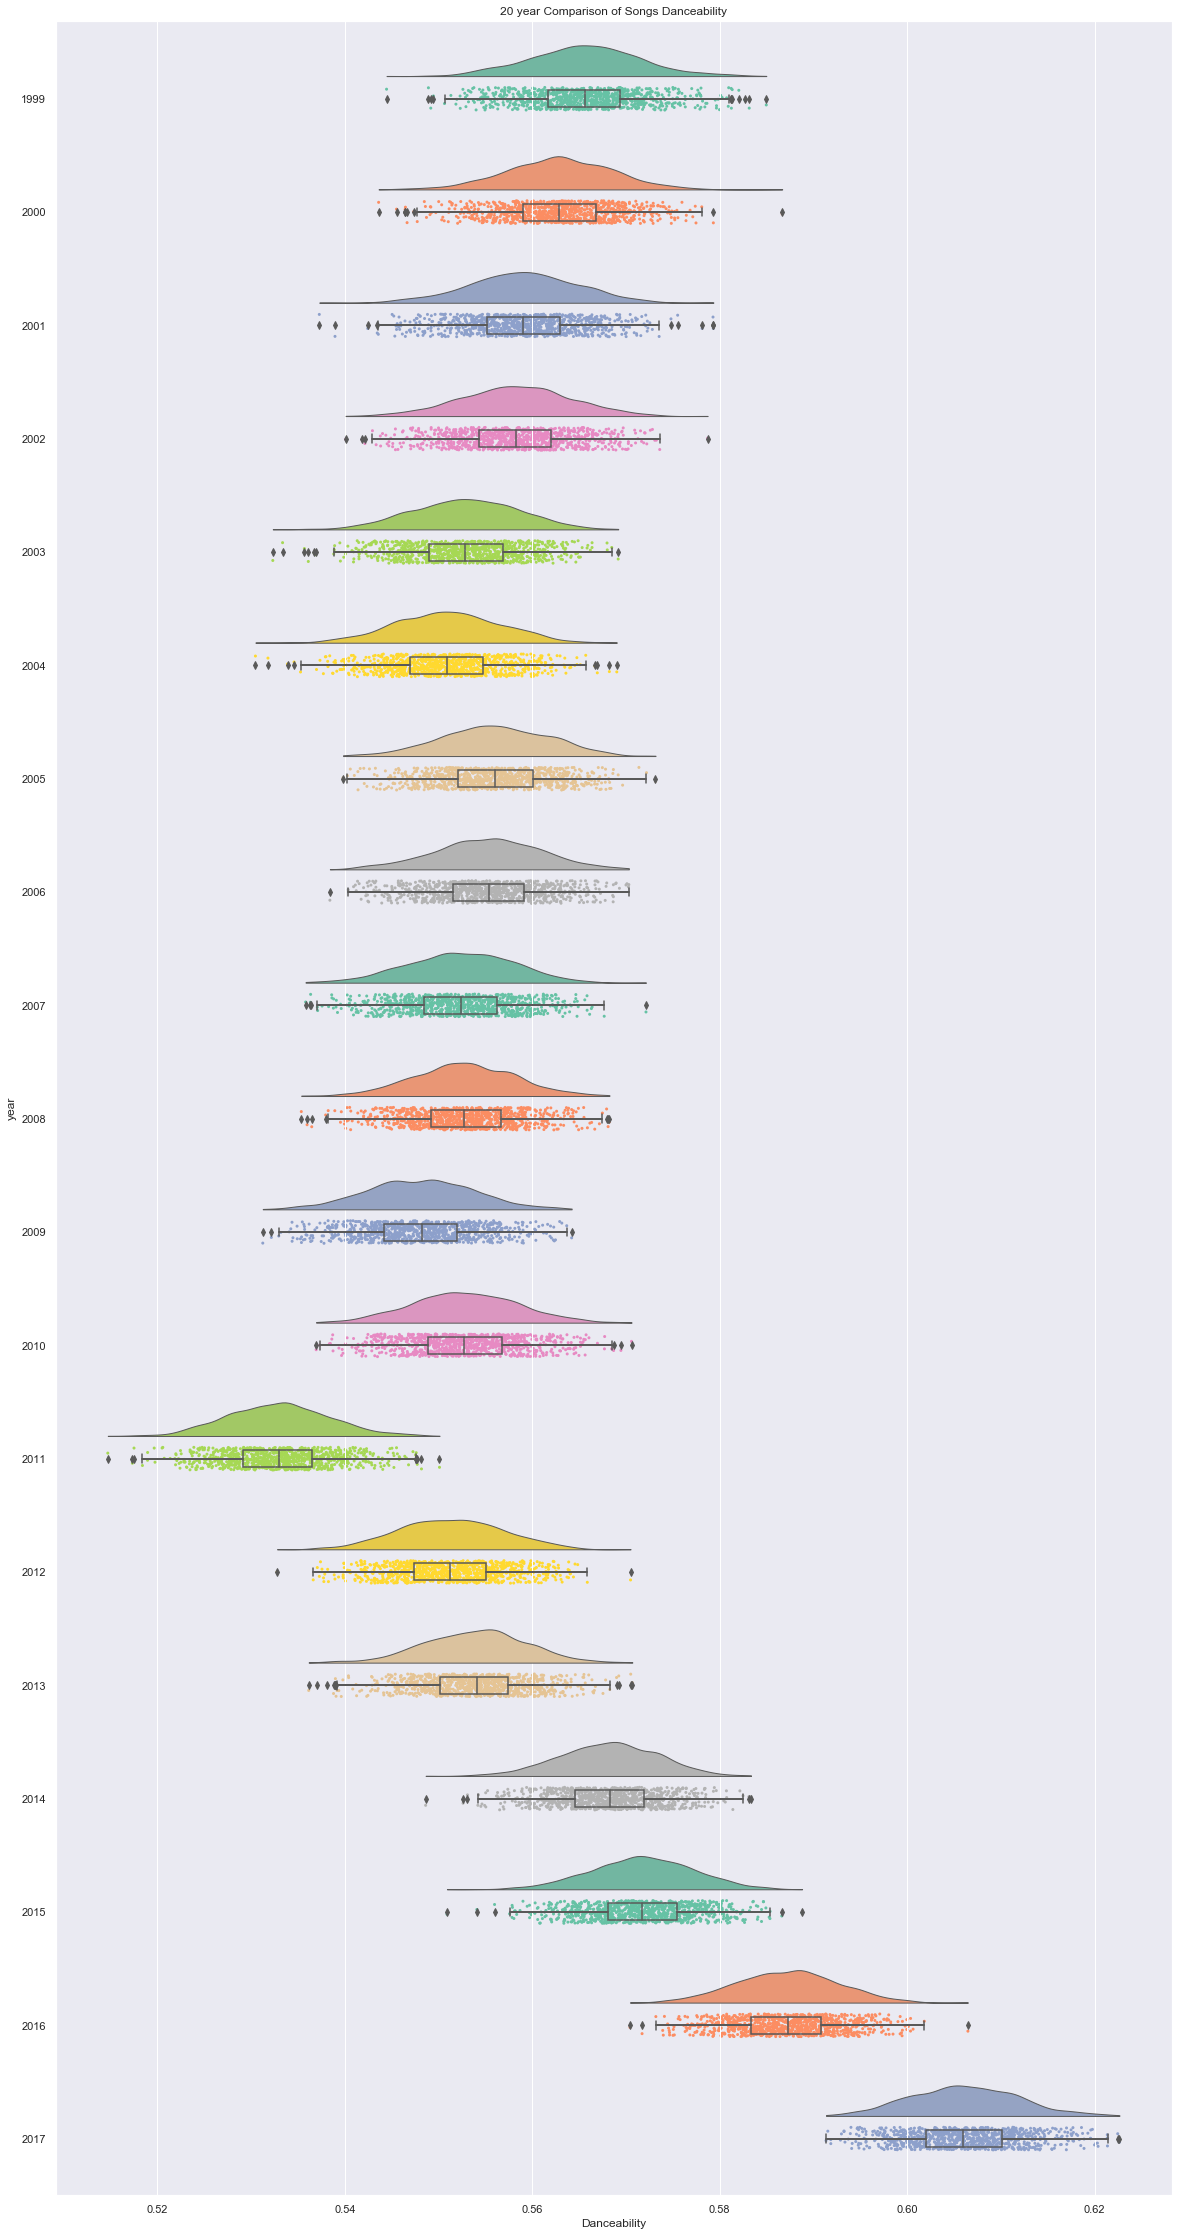

In [424]:
dx = "year"; dy = 0; ort = "h"; pal = "Set2"; sigma = .2
f, ax = plt.subplots(figsize=(20, 40))

pt.RainCloud(x = dx, y = dy, data = dfs_concat, palette = pal, bw = sigma,
                 width_viol = .6, ax = ax, orient = ort, move = 0)
plt.xlabel('Danceability')
plt.title('20 year Comparison of Songs Danceability')

In [61]:
lst_dfs = []
for x in range(1999,2019):
    print(x)
    df = twenty_years[twenty_years['year']== str(x)]
    dist =  create_sample_distribution(df['energy'])
    dist_df = pd.DataFrame(dist)
    dist_df['year']= x
    lst_dfs.append(dist_df)

dfs_concat= pd.concat(lst_dfs)

1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018


Text(0.5, 1.0, '20 year Comparison of Songs Energy')

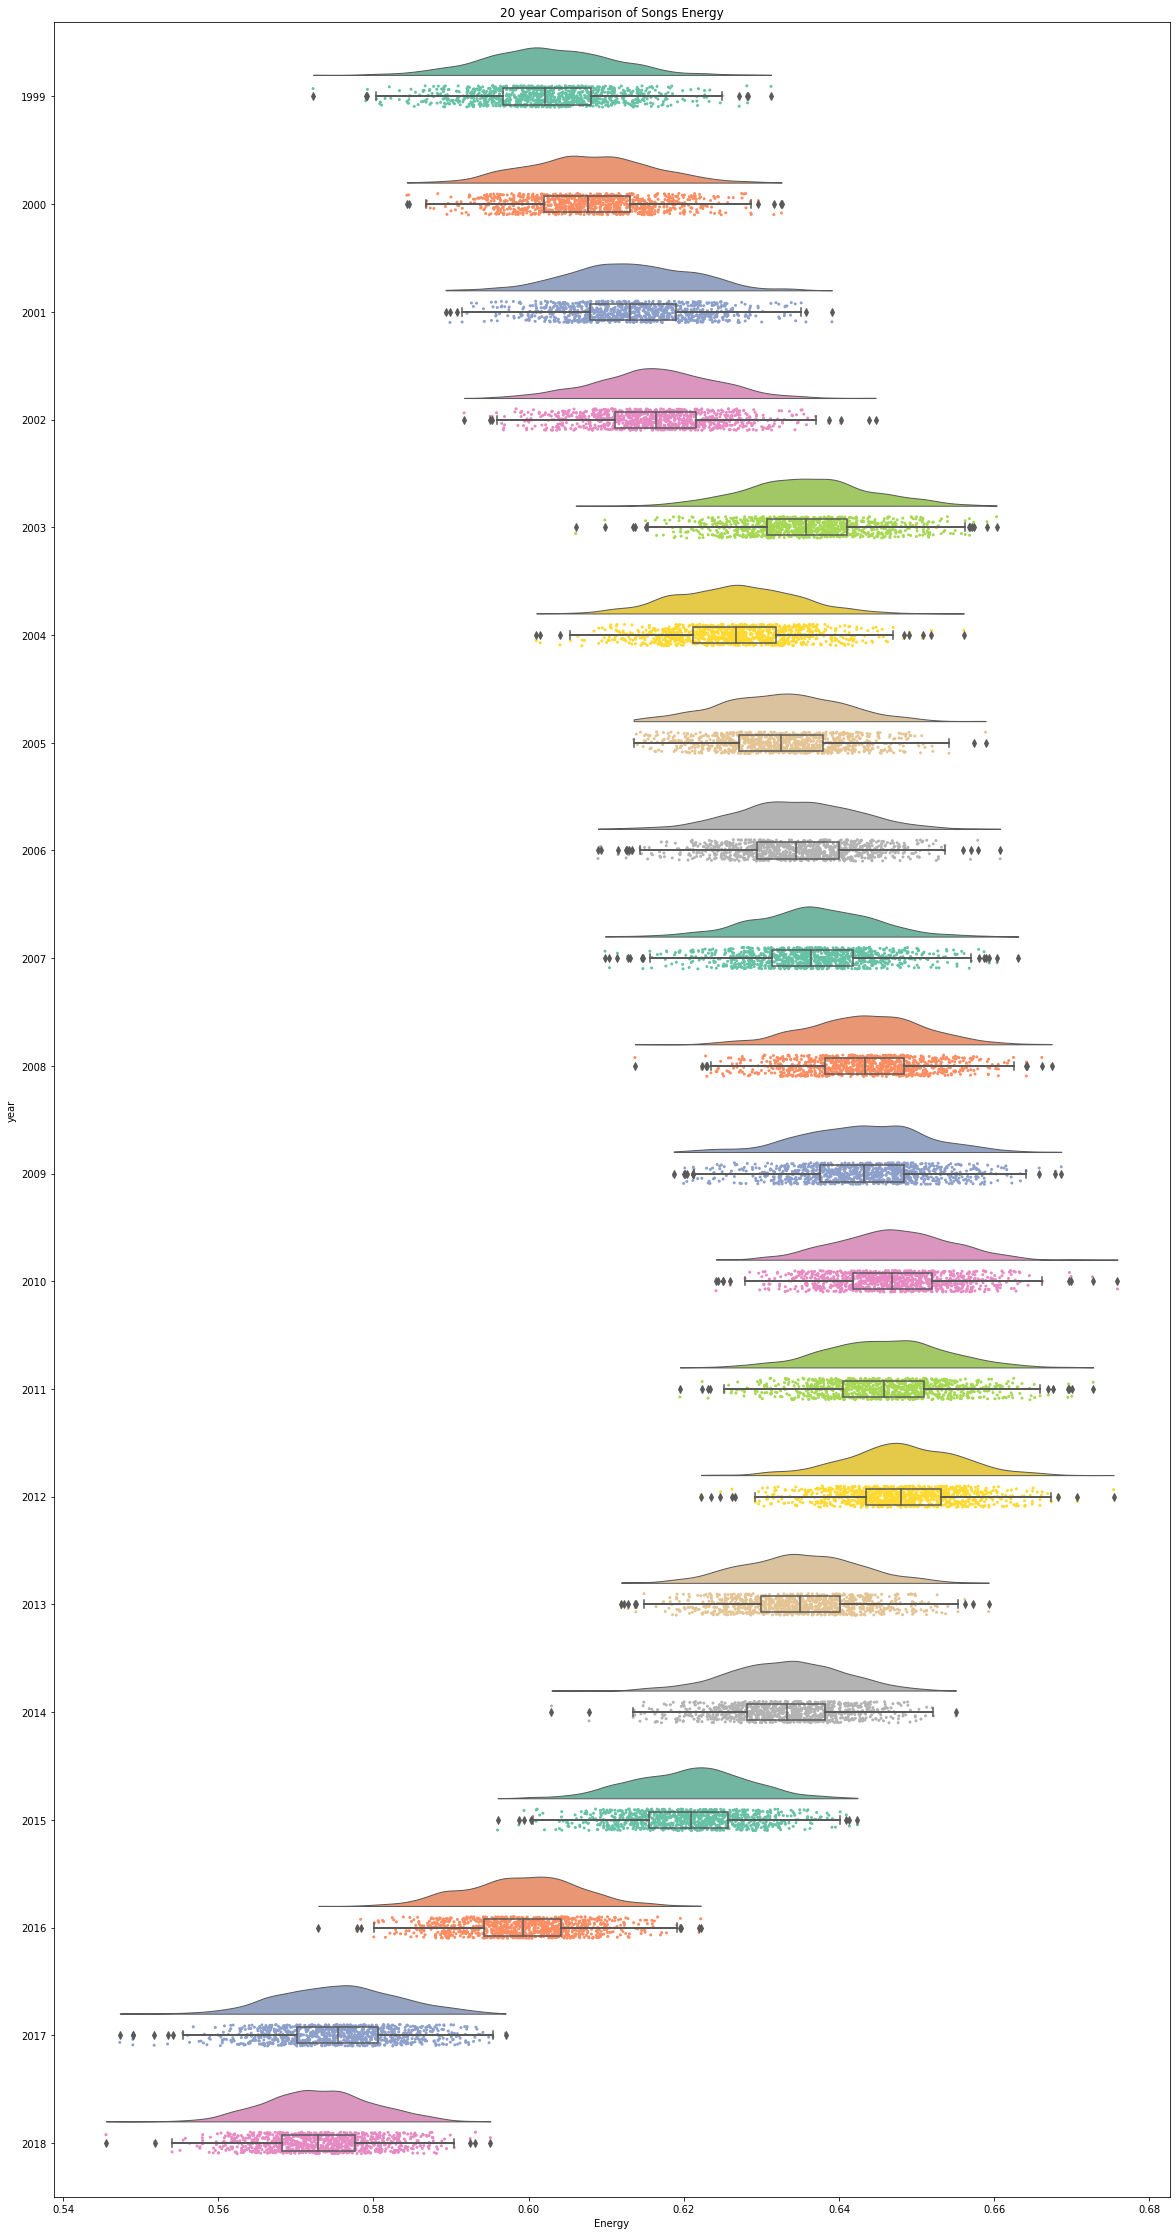

In [62]:
dx = "year"; dy = 0; ort = "h"; pal = "Set2"; sigma = .2
f, ax = plt.subplots(figsize=(20, 40))

pt.RainCloud(x = dx, y = dy, data = dfs_concat, palette = pal, bw = sigma,
                 width_viol = .6, ax = ax, orient = ort, move = 0)
plt.xlabel('Energy')
plt.title('20 year Comparison of Songs Energy')

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import hypothesis_tests as ht

Means: 
2009 mean value: 0.7260139999999999
Population mean value: 0.6421997
Standard Deviations
2009 std value: 0.022248997539215092
pop std value: 0.02760992051165667
p-value 3.1120415798730447e-59
we reject null hypothesis


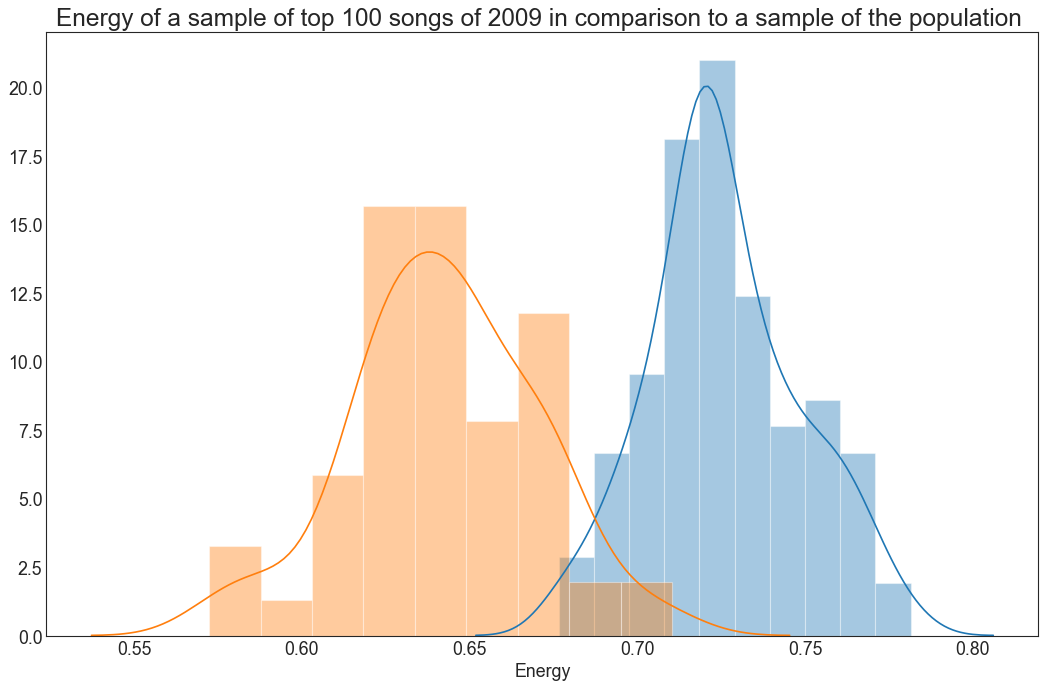

In [3]:
status, viz = ht.hypothesis_test_one(alpha = 0.05,verbose = True)


 Welch's t-test= -265.6774 
 p-value = 0.0000 
 Welch-Satterthwaite Degrees of Freedom= 1995.5525


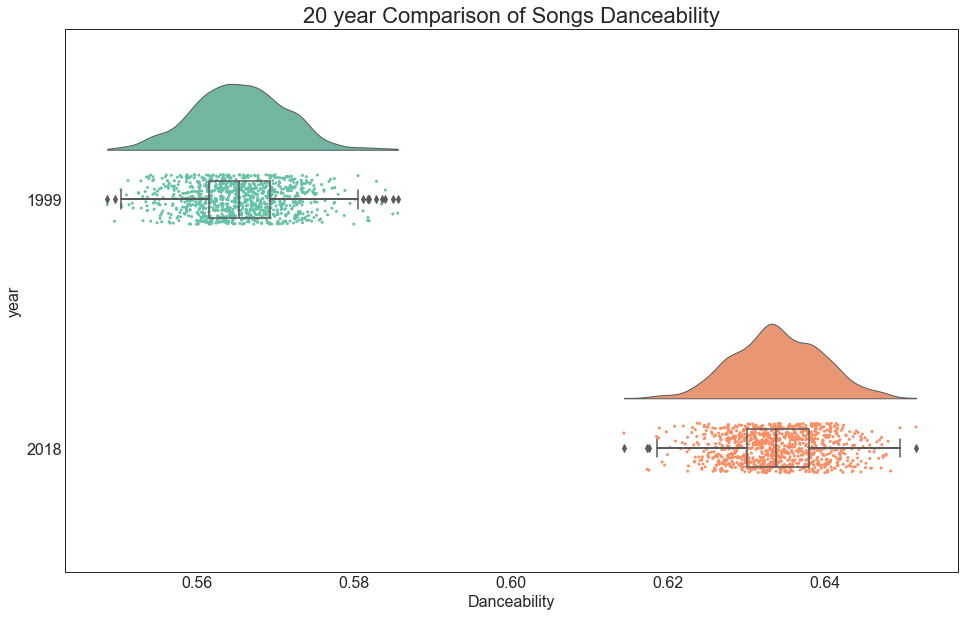

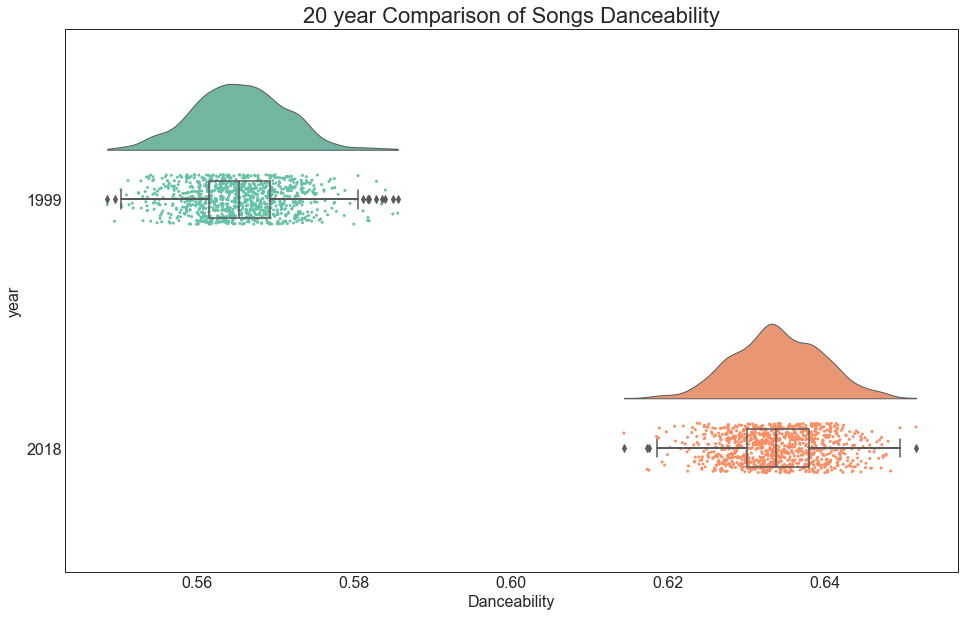

In [18]:
ht.hypothesis_test_four()

In [35]:
h = print('Helo Fadi')

Helo Fadi


In [36]:
h